# Infos

- Pre-process using an 8–30 Hz filter and a notch filter
- Sampled at 125 Hz

# Required libraries

In [1]:
try:
    from google.colab import drive
    usingColab = True
    print("Using Colab. Downloading necessary libraries...")
    !pip install nolds EntropyHub eeglib # Feature extraction
    !pip install gdown tqdm -U           # Downloading files
    !pip install scikit-learn            # Preprocessing
except:
    usingColab = False
    print("Not using Colab. Assuming all libraries have been already downloaded...")
    pass

Not using Colab. Assuming all libraries have been already downloaded...


# Imports

In [2]:
import os
import random
import zipfile

import gdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

c:\Users\gianc\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Check for availability of CUDA support

In [3]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print('Cuda available: {}'.format(torch.cuda.is_available()))
    print("GPU: " + torch.cuda.get_device_name(torch.cuda.current_device()))
    print("Total memory: {:.1f} GB".format((float(torch.cuda.get_device_properties(0).total_memory / (1024 ** 3)))))
    print("===================================================")
else:
    device = torch.device("cpu")
    print('Cuda not available, so using CPU. Please consider switching to a GPU runtime before running the notebook!')

Cuda available: True
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Total memory: 6.0 GB


# Dataset

## Download from Drive

In [4]:
if os.path.exists("Dataset"):    
    downloadDataset = False
else:
    downloadDataset = True

if(downloadDataset):
    EEG_Dataset_URL = 'https://drive.google.com/uc?id=' + '1Ijm2rxaGksYbnl1AQIYdConiNMrA1N0R' + '&export=download&confirm=t'
    EEG_zip_name = "EEG_Dataset_Final.zip"
    extracted_dir = "Dataset/"

    print(f"Downloading {EEG_zip_name}...")
    gdown.download(EEG_Dataset_URL, EEG_zip_name, quiet=False)

    # Create a ZipFile object and open the ZIP file
    with zipfile.ZipFile(EEG_zip_name, 'r') as zip_ref:
        # Extract all the contents to the specified directory
        zip_ref.extractall(extracted_dir)

    print(f"Files extracted to {extracted_dir}")

    os.remove(EEG_zip_name)
else:
    print("Dataset already exists. Not downloading again.")

Dataset already exists. Not downloading again.


## Helper functions

In [5]:
# First, get the electrodes positions for each subject starting from the TSV files
# This is needed to correctly name the column in the Pandas Dataframe that will be created later
def get_electrodes_positions(mode = 'Unhealthy', mapping: dict = None):
    selected_files = []

    for _, values in mapping.items():
        for value in values:
            for run in range(1, 13):  # Assuming runs go from 1 to 13
                filename = f"Dataset/{mode}/{value}_task-motion_run-{run}_electrodes.tsv"
                if os.path.exists(filename):
                    selected_files.append(filename)
                    break  # Break the loop once a file is found for the subject
                else:
                    filename = f"Dataset/{mode}/{value}_task-motorimagery_run-{run}_electrodes.tsv"
                    if os.path.exists(filename):
                        selected_files.append(filename)
                        break
            if filename in selected_files:
                break  # Break the outer loop if a file is found for the subject
    return selected_files

# Concatenate all DataFrames in the list into a single DataFrame
# This is done for both the Unhealthy and Healthy datasets
def get_final_csv(mode = 'Unhealthy', subject = 'S1'):
    # Various lists to store the dataframes
    dfs = []
    file_paths = []

    # Get file paths and reorder them
    file_paths = [f"Dataset/{mode}/{file}" for file in os.listdir(f"Dataset/{mode}/") if file.startswith(subject) and file.endswith(".csv")]

    # Read each CSV file into a DataFrame and append it to the list
    for file_path in file_paths:
        df = pd.read_csv(file_path)

        # Shuffle the DataFrame every 125 rows 
        num_rows = df.shape[0]
        for start_idx in range(0, num_rows, 125):
            if(start_idx + 125 > num_rows):
                df = df.iloc[:start_idx, :]
                break
            end_idx = min(start_idx + 125, num_rows)
            df.iloc[start_idx:end_idx, :] = df.iloc[start_idx:end_idx, :].sample(frac=1, random_state=42)

        dfs.append(df)

    # Shuffle the list of Dataframes
    random.shuffle(dfs)
    
    # Concatenate all DataFrames in the list into a single DataFrame
    concatenated_df = pd.concat(dfs, axis=0, ignore_index=True)
    return concatenated_df

# Convert the labels from string to numerical classes
def convert_labels(df: pd.DataFrame):
    label_encoder = LabelEncoder() # Use LabelEncoder to convert string labels to numerical classes
    df['Label'] = label_encoder.fit_transform(df.iloc[:, -2].values) # Update the DataFrame with the encoded labels
    return df

# Reorder columns based on the TSV files
def reorder_columns(df: pd.DataFrame, mode = 'Unhealthy', electrodes_locations = None):
    # Get the column names
    cols = list(df.columns)

    # If in 'Unhealthy' mode, move 'Label' to the end as it should be
    if mode == 'Unhealthy':
        del cols[cols.index('labels')]
        cols.append('labels')

    # Reorder the columns
    df = df[cols]

    # Load corresponding electrodes file and set column names
    channel_dataframe = pd.read_csv(electrodes_locations[0], sep='\t')

    # Append 'Label' to the end of the column names and feed it to the DataFrame
    if mode == 'Unhealthy':
        # Only consider until the second last column because no CSV has that channel location (Pz)
        # It would've thrown an error otherwise because it would've tried to rename a column that doesn't exist
        channel_column = np.append((channel_dataframe.iloc[:, 0].values)[:-1], 'Label')

        # Change column names to reflect the actual channel names
        name_mapping = {'CP1': 'Cp1',
                        'CP2': 'Cp2',
                        'CP5': 'Cp5',
                        'CP6': 'Cp6',
                        'FC1': 'Fc1',
                        'FC2': 'Fc2',
                        'FC5': 'Fc5',
                        'FC6': 'Fc6'}
        
        # Replace the names in the array
        for key, value in name_mapping.items():
            channel_column = np.where(channel_column == key, value, channel_column)
            
        final_channel_names = channel_column
    else:
        final_channel_names = np.append(channel_dataframe.iloc[:, 0].values, 'Label')

    df.columns = final_channel_names
    return df

## Get electrodes positions

In [6]:
# Mapping`of the subject names into corresponding sub-IDs used in the dataset
mapping = {
    "S1": ["sub-001", "sub-01"],
    "S2": ["sub-003", "sub-02"],
    "S3": ["sub-009", "sub-03"],
    "S4": ["sub-022", "sub-04"],
    "S5": ["sub-039", "sub-05"],
    "S6": ["sub-040", "sub-06"],
    "S7": ["sub-058", "sub-07"],
}

unhealthy_electrodes = get_electrodes_positions(mode='Unhealthy', mapping=mapping)
healthy_electrodes = get_electrodes_positions(mode='Healthy', mapping=mapping)

print("Unhealthy electrodes:")
for electrode in unhealthy_electrodes:
    print(electrode)
print("---------------------")
print("Healthy electrodes:")
for electrode in healthy_electrodes:
    print(electrode)
print("---------------------")

Unhealthy electrodes:
Dataset/Unhealthy/sub-01_task-motorimagery_run-1_electrodes.tsv
Dataset/Unhealthy/sub-02_task-motorimagery_run-1_electrodes.tsv
Dataset/Unhealthy/sub-03_task-motorimagery_run-1_electrodes.tsv
Dataset/Unhealthy/sub-04_task-motorimagery_run-1_electrodes.tsv
Dataset/Unhealthy/sub-05_task-motorimagery_run-1_electrodes.tsv
Dataset/Unhealthy/sub-06_task-motorimagery_run-1_electrodes.tsv
Dataset/Unhealthy/sub-07_task-motorimagery_run-1_electrodes.tsv
---------------------
Healthy electrodes:
Dataset/Healthy/sub-001_task-motion_run-1_electrodes.tsv
Dataset/Healthy/sub-003_task-motion_run-1_electrodes.tsv
Dataset/Healthy/sub-009_task-motion_run-1_electrodes.tsv
Dataset/Healthy/sub-022_task-motion_run-1_electrodes.tsv
Dataset/Healthy/sub-039_task-motion_run-5_electrodes.tsv
Dataset/Healthy/sub-040_task-motion_run-3_electrodes.tsv
Dataset/Healthy/sub-058_task-motion_run-2_electrodes.tsv
---------------------


## Get the corresponding CSV for each subject

In [7]:
# Get all the CSVs for each subject and concatenate them into a single DataFrame
# This is done for both Healthy and Unhealthy datasets.
dfs = []
dfs_unhealthy = []
final_df = None
final_df_unhealthy = None

for key, value in tqdm(mapping.items(), desc="Processing CSVs"):

    dataframe_sub = get_final_csv(mode='Healthy', subject = key)
    dataframe_sub_unhealthy = get_final_csv(mode='Unhealthy', subject = key)

    dfs.append(dataframe_sub)
    dfs_unhealthy.append(dataframe_sub_unhealthy)

# Concatenate all DataFrames in the list into a single DataFrame
final_df = pd.concat(dfs, ignore_index=True)
final_df_unhealthy = pd.concat(dfs_unhealthy, ignore_index=True)

# Reorder columns based on the TSV files
final_df = reorder_columns(final_df, mode='Healthy', electrodes_locations=healthy_electrodes)
final_df_unhealthy = reorder_columns(final_df_unhealthy, mode='Unhealthy', electrodes_locations=unhealthy_electrodes)

# Add a column to the DataFrame to indicate the condition (Healthy or Unhealthy)
#   - Healthy = 0
#   - Unhealthy = 1
final_df['Condition'] = 0
final_df_unhealthy['Condition'] = 1

print("---------------- H E A L T H Y ----------------")
print(F"Features example:\n{final_df.iloc[0, :-2].values}")
print(F"Motor task example:\n{final_df.iloc[0, -2]} ")
print(F"Condition example:\n{final_df.iloc[0, -1]} ")
print("-----------------------------------------------")
print(F"Dataframe shape: {final_df.shape}")
print("-------------- U N H E A L T H Y --------------")
print(F"Features example:\n{final_df_unhealthy.iloc[0, :-2].values}")
print(F"Motor task example:\n{final_df_unhealthy.iloc[0, -2]} ")
print(F"Condition example:\n{final_df_unhealthy.iloc[0, -1]} ")
print("-----------------------------------------------")
print(F"Dataframe shape: {final_df_unhealthy.shape}")
print("-----------------------------------------------")

Processing CSVs: 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]

---------------- H E A L T H Y ----------------
Features example:
[-49.93029 -27.67471 -27.52487 -45.85265 -36.56291 -34.8497 -63.83421
 -52.63934 -5.53137 -13.23921 -36.6793 -29.60554 -11.36031 -41.84321
 6.864106 11.68825 -4.979896 -1.22721 -4.830249 -16.01143 -28.28695
 -59.80394 -50.43885 -50.36382 -41.0409 -37.27557 -66.65372 -58.58808
 -29.10051 -52.23442 -27.44865 -35.08705 -47.35172 -49.82998 -49.39008
 -43.85049 -47.17167 -31.51139 -36.36313 -53.77351 -24.03282 -71.37685
 -6.14304 -17.52465 -3.597137 -45.26395 21.63019 20.86694 20.11819 14.9826
 4.910687 6.062759 -8.204636 -25.69847 -26.03493 28.13515 17.35871
 -5.106737 -15.40151 -15.11947 20.02988 -1.385154 9.969332 17.4178]
Motor task example:
TASK4T1 
Condition example:
0 
-----------------------------------------------
Dataframe shape: (10500, 66)
-------------- U N H E A L T H Y --------------
Features example:
[2.049983 0.3901227 -0.518605 -0.09012378 -22.22385 2.501927 1.711733
 5.534765 -0.05559913 3.734228 3.898871 -

## Fix-up useless channels for both Datasets

In [8]:
# Remove unnecessary channels that are not related to motor tasks
# Also 'Pz' is removed because it doesn't exist in the Unhealthy dataset
useless_channels = ['Af3', 'Af4', 'Af7', 'Af8', 'Afz', 
                    'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 
                    'Fp1', 'Fp2', 'Fpz', 
                    'Ft7', 'Ft8', 'Fz', 
                    'Iz', 
                    'O1', 'O2', 'Oz', 
                    'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 
                    'Po3', 'Po4', 'Po7', 'Po8', 'Poz', 
                    'Pz', 
                    'T10', 'T7', 'T8', 'T9', 
                    'Tp7', 'Tp8']

# Iterate over each channel and remove it if it exists
for channel in useless_channels:
    if channel in final_df.columns:
        final_df = final_df.drop(channel, axis=1)

    if channel in final_df_unhealthy.columns:
        final_df_unhealthy = final_df_unhealthy.drop(channel, axis=1)

print("---------------- H E A L T H Y ----------------")
print(F"Features example:\n{final_df.iloc[0, :-2].values}")
print(F"Motor task example:\n{final_df.iloc[0, -2]} ")
print(F"Condition example:\n{final_df.iloc[0, -1]} ")
print("-----------------------------------------------")
print(F"Dataframe shape: {final_df.shape}")
print("-------------- U N H E A L T H Y --------------")
print(F"Features example:\n{final_df_unhealthy.iloc[0, :-2].values}")
print(F"Motor task example:\n{final_df_unhealthy.iloc[0, -2]} ")
print(F"Condition example:\n{final_df_unhealthy.iloc[0, -1]} ")
print("-----------------------------------------------")
print(F"Dataframe shape: {final_df_unhealthy.shape}")
print("-----------------------------------------------")

---------------- H E A L T H Y ----------------
Features example:
[-49.93029 -27.67471 -27.52487 -45.85265 -36.56291 -34.8497 -63.83421
 -52.63934 -5.53137 -13.23921 -36.6793 -29.60554 -11.36031 -41.84321
 6.864106 11.68825 -4.979896 -1.22721 -4.830249 -16.01143 -28.28695]
Motor task example:
TASK4T1 
Condition example:
0 
-----------------------------------------------
Dataframe shape: (10500, 23)
-------------- U N H E A L T H Y --------------
Features example:
[2.049983 0.3901227 -0.518605 -0.09012378 -22.22385 2.501927 1.711733
 5.534765 -0.05559913 3.734228 3.898871]
Motor task example:
boundary 
Condition example:
1 
-----------------------------------------------
Dataframe shape: (115000, 13)
-----------------------------------------------


## Merge Healthy/Unhealthy Dataframes in one

In [9]:
# Create a merged dataframe with columns from the healthy dataset
merged_df = final_df.copy()

# Identify common channels between healthy and unhealthy datasets
common_channels = set(final_df.columns).intersection(final_df_unhealthy.columns)

# Concatenate the unhealthy dataset to the merged dataframe
merged_df = pd.concat([merged_df, final_df_unhealthy], ignore_index=True, sort=False)

# Features have to be a tensor [batch_size, num_features] where num_features = 21
# As of now, the unhealthy dataset has 11 features, so the other 10 are NaNs.
merged_df = merged_df.dropna(axis=1)    # Or drop columns with NaN values

# Convert labels to numerical classes
merged_df = convert_labels(df=merged_df)

# Example of the resulting dataframe
print(f"Merged DataFrame dimensions: {merged_df.shape}")
merged_df.head()

Merged DataFrame dimensions: (125500, 13)


,Fc5,Fc1,Fc2,Fc6,C3,Cz,C4,Cp5,Cp1,Cp2,Cp6,Label,Condition
0,-49.930290,-27.52487,-36.562910,-63.834210,-5.531370,-36.67930,-11.36031,6.864106,-4.979896,-4.830249,-28.286950,20,0
1,4.291434,22.72633,30.796850,23.597970,30.132160,51.21453,24.73619,17.021270,29.964720,29.731720,-5.965919,19,0
2,-6.367405,14.67368,22.213320,5.789613,17.317950,46.05441,11.81701,8.950344,28.993270,29.051220,-11.929990,19,0
3,-2.182859,-12.68018,-3.107878,9.535013,-2.663379,-13.97225,-17.66672,-2.717516,-18.669940,-23.661760,-18.494210,19,0
4,-45.742270,-17.63917,-67.239100,-29.302590,-11.290380,-29.16850,1.12077,18.392280,-8.475563,-2.351571,12.392470,21,0


## Feature Extraction process
In this case, the use of the HE (Hurst Exponent) or the ShEn approach are illustrated.

In [10]:
def compute_feature_extraction(method: str):
    final_exponents = {}

    if(method == 'Hurst'):
        import nolds
        # Loop through the merged_df every 125 rows and calculate the Hurst Exponent for each EEG signal
        # The Hurst Exponent is a measure of the "long-term memory" of a time series
        # It ranges between 0 and 1, where:
        #   - 0.5 indicates a random walk (Brownian motion)
        #   - < 0.5 indicates mean-reverting behavior
        #   - > 0.5 indicates trending behavior

        # Create a hurst_exponents dictionary to store the results with the column names as keys
        hurst_exponents = {}

        for i, start_idx in enumerate(tqdm(range(0, merged_df.shape[0], 125), desc="Processing EEGs")):
            end_idx = min(start_idx + 125, merged_df.shape[0])
            eeg_data = merged_df.iloc[start_idx:end_idx, :11]
            for column in eeg_data.columns:
                final_exponents.update({column: nolds.hurst_rs(eeg_data[column], debug_plot=False)})
            # Add the condition to the dictionary
            final_exponents.update({'Label': 0})
            final_exponents.update({'Condition': merged_df.iloc[start_idx, -1]})
            hurst_exponents[str(i)] = {k: v for k, v in final_exponents.items()}
        return hurst_exponents
    elif(method == 'CD'):
        import nolds
        correlation_dimension = {}

        for i, start_idx in enumerate(tqdm(range(0, merged_df.shape[0], 125), desc="Processing EEGs")):
            end_idx = min(start_idx + 125, merged_df.shape[0])
            eeg_data = merged_df.iloc[start_idx:end_idx, :11]
            for column in eeg_data.columns:
                final_exponents.update({column: nolds.corr_dim(eeg_data[column], emb_dim=3)})
            # Add the condition to the dictionary
            final_exponents.update({'Label': 0})
            final_exponents.update({'Condition': merged_df.iloc[start_idx, -1]})
            correlation_dimension[str(i)] = {k: v for k, v in final_exponents.items()}
        return correlation_dimension
    elif(method == 'KolmEn'):
        import EntropyHub as EH
        kolmogorov = {}

        for i, start_idx in enumerate(tqdm(range(0, merged_df.shape[0], 125), desc="Processing EEGs")):
            end_idx = min(start_idx + 125, merged_df.shape[0])
            eeg_data = merged_df.iloc[start_idx:end_idx, :11]
            for column in eeg_data.columns:
                final_exponents.update({column: EH.K2En(eeg_data[column], m=1, tau=1)[0][0]})
            # Add the condition to the dictionary
            final_exponents.update({'Label': 0})
            final_exponents.update({'Condition': merged_df.iloc[start_idx, -1]})
            kolmogorov[str(i)] = {k: v for k, v in final_exponents.items()}
        return kolmogorov
    elif(method == 'KolmEn_LE'):
        import EntropyHub as EH
        import nolds
        kolmogorov_le = {}

        for i, start_idx in enumerate(tqdm(range(0, merged_df.shape[0], 125), desc="Processing EEGs")):
            end_idx = min(start_idx + 125, merged_df.shape[0])
            eeg_data = merged_df.iloc[start_idx:end_idx, :11]
            for column in eeg_data.columns:
                final_exponents.update({column: EH.K2En(eeg_data[column], m=1, tau=1)[0][0] + nolds.lyap_r(eeg_data[column])})
            # Add the condition to the dictionary
            final_exponents.update({'Label': 0})
            final_exponents.update({'Condition': merged_df.iloc[start_idx, -1]})
            kolmogorov_le[str(i)] = {k: v for k, v in final_exponents.items()}
        return kolmogorov_le
    elif(method == 'DFA'):
        from eeglib.helpers import CSVHelper
        from eeglib.features import DFA

        # Set the window size for the DFA
        window_size = 125

        # Save the DataFrame to a temporary file
        channel_df = merged_df.iloc[:, :-2]
        channel_df.to_csv('features_df1.csv', index=False)

        # New empty DataFrame to store the results
        DFA_df = pd.DataFrame()

        features_dfEEGlib = CSVHelper('features_df1.csv', windowSize=window_size)
        for eeg in tqdm(features_dfEEGlib, total=int(len(merged_df)/window_size), desc="Processing EEGs"):
            DFA_df = pd.concat([DFA_df, pd.Series(eeg.DFA()).to_frame().T], ignore_index=True)
        
        # Update column names
        DFA_df.columns = channel_df.columns

        # Add missing columns and initialize them with 0
        DFA_df['Label'] = 0 # Labels
        DFA_df['Condition'] = 0 # Conditions

        # Extract values from 'condition' column of the merged_df
        conditions_to_copy = merged_df['Condition'].iloc[::window_size].astype(int).tolist()

        # Update values in final DataFrame for each row
        for i in range(len(DFA_df)):
            DFA_df.loc[i, 'Condition'] = conditions_to_copy[i % len(conditions_to_copy)]

        # Remove the temporary file
        os.remove('features_df1.csv')

        return DFA_df
    else:
        raise ValueError("Invalid method. Please choose one of the following: Hurst, CD, KolmEn, KolmEn_LE, DFA")

In [11]:
method = 'Hurst' # 'Hurst / 'CD' / 'KolmEn' / 'KolmEn_LE' / 'DFA'

if (method != ''):
    features_extracted = compute_feature_extraction(method=method)

    # Convert Hurst Exponents to DataFrame for easier analysis
    if(method != 'DFA'):
        features_extracted = pd.DataFrame.from_dict(features_extracted, orient='index', columns=merged_df.columns)

    merged_df = features_extracted

print(f"Shape: {merged_df.shape}")

Processing EEGs:   0%|          | 2/1004 [00:00<02:56,  5.67it/s]c:\Users\gianc\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
Processing EEGs:   0%|          | 3/1004 [00:00<03:40,  4.55it/s]c:\Users\gianc\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
Processing EEGs:   0%|          | 4/1004 [00:00<03:00,  5.55it/s]c:\Users\gianc\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
Processing EEGs:   1%|          | 10/1004 [00:01<03:08,  5.27it/s]c:\Users\gianc\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not w

Shape: (1004, 13)


## Print out an example from the dataset
Print channel Fc2 / Fc5 / Cp6 for Healthy and Unhealthy

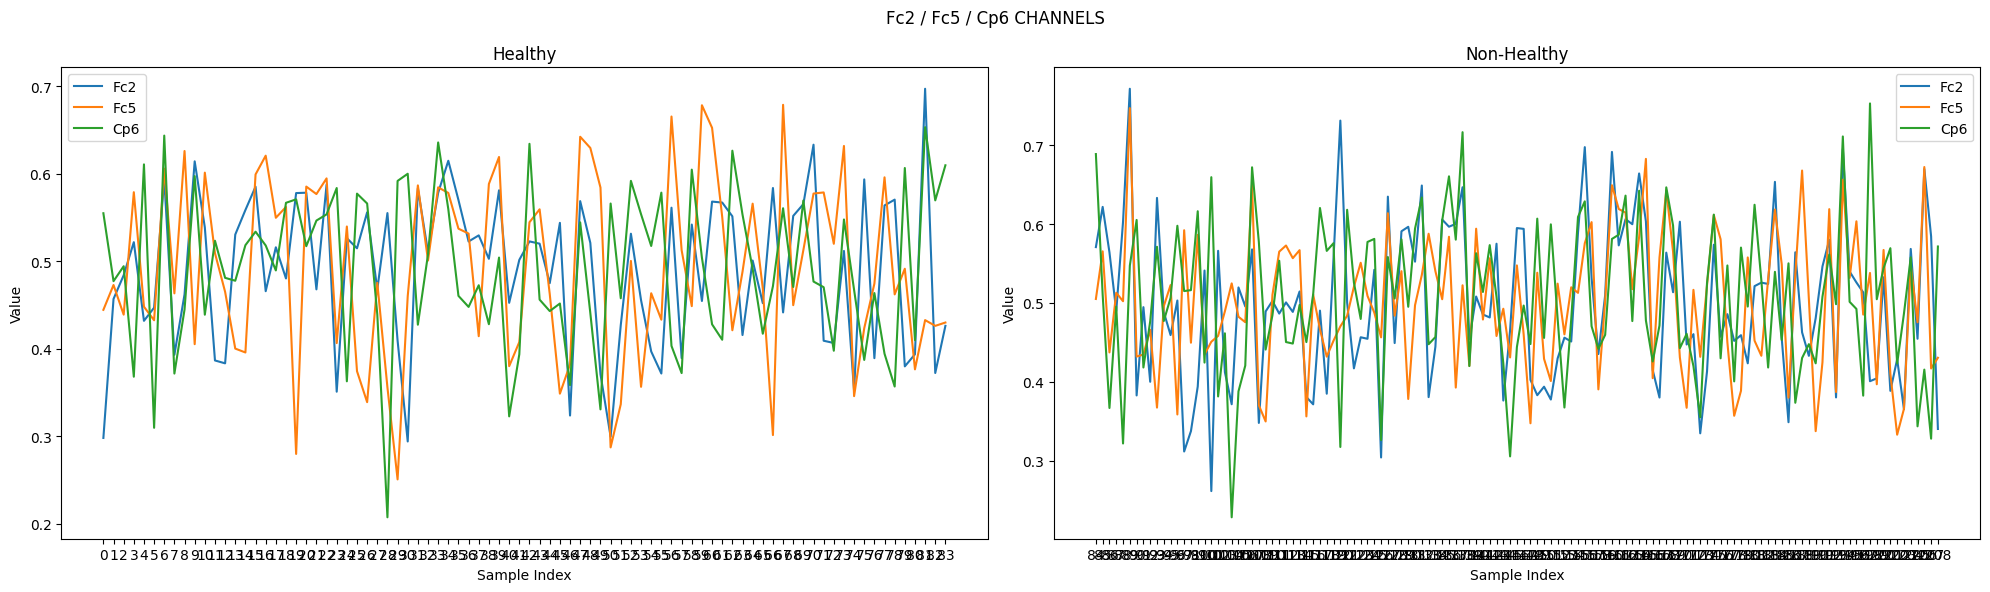

In [12]:
# Plotting example
fc2_electrode = 'Fc2'
fc5_electrode = 'Fc5'
cp6_electrode = 'Cp6'
len_signal = 125

# Plot for healthy data
plt.figure(figsize=(20, 6))
plt.suptitle("Fc2 / Fc5 / Cp6 CHANNELS")

plt.subplot(1, 2, 1)
plt.plot(merged_df[merged_df['Condition'] == 0][fc2_electrode][:len_signal], label=f'{fc2_electrode}', linestyle='-')
plt.plot(merged_df[merged_df['Condition'] == 0][fc5_electrode][:len_signal], label=f'{fc5_electrode}', linestyle='-')
plt.plot(merged_df[merged_df['Condition'] == 0][cp6_electrode][:len_signal], label=f'{cp6_electrode}', linestyle='-')
plt.xlabel('Sample Index')
plt.ylabel("Value")
plt.title('Healthy')
plt.legend()

# Plot for non-healthy data
plt.subplot(1, 2, 2)
plt.plot(merged_df[merged_df['Condition'] == 1][fc2_electrode][:len_signal], label=f'{fc2_electrode}', linestyle='-')
plt.plot(merged_df[merged_df['Condition'] == 1][fc5_electrode][:len_signal], label=f'{fc5_electrode}', linestyle='-')
plt.plot(merged_df[merged_df['Condition'] == 1][cp6_electrode][:len_signal], label=f'{cp6_electrode}', linestyle='-')
plt.xlabel('Sample Index')
plt.ylabel("Value")
plt.title('Non-Healthy')
plt.legend()

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

## Get the actual Dataloader

In [13]:
class CustomDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame):
        self.data = dataframe.values.astype('float32')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        # Features
        features = torch.tensor(self.data[idx, :-2], dtype=torch.float32)

        # Motor Task
        motor_task = torch.tensor(self.data[idx, -2], dtype=torch.float32)

        # Condition
        condition = torch.tensor(self.data[idx, -1], dtype=torch.float32)

        return features, motor_task, condition

In [14]:
# In this section, simply scale the values between 0 and 1
# for the features and create custom datasets and data loaders
def scale_values(df: pd.DataFrame, scaler: MinMaxScaler):
    features = df.iloc[:, :-2] # Features
    motor_tasks = df.iloc[:, -2] # Motor Task
    conditions = df.iloc[:, -1] # Condition

    features.reset_index(drop=True, inplace=True)
    motor_tasks.reset_index(drop=True, inplace=True)
    conditions.reset_index(drop=True, inplace=True)

    df_scaled = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)
    final_df = pd.concat([df_scaled, motor_tasks, conditions], axis=1)
    
    if(final_df.isna().any().any()):
        print("Dataframe contains NaN values. Removing them...")
        final_df = final_df.dropna()  # Remove rows with NaN values
    final_df.columns = df.columns

    return final_df

# Scale the values
scaler = MinMaxScaler()

batch_size = 64 # Adjust as needed

# Scale the values
if(method != 'DFA' and method != 'Hurts'):
    merged_df = scale_values(merged_df, scaler)

# Split the dataset into train and test sets
train_df, test_df = train_test_split(merged_df, test_size=0.2, random_state=2047315)

# Create custom datasets and data loaders
train_dataset = CustomDataset(pd.DataFrame(train_df))
test_dataset = CustomDataset(pd.DataFrame(test_df))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of samples in train dataset: {len(train_dataset)}")
print("------------------------------------------------------")
print(f"Number of batches in train loader: {len(train_loader)}")
print("------------------------------------------------------")
batch = next(iter(train_loader))
print(f"Shape of batch (X): {batch[0].shape}")
print(f"Shape of batch (Motor Task): {batch[1].shape}")
print(f"Shape of batch (Condition): {batch[2].shape}")
print("# ------------------------------------------------------ #")

Number of samples in train dataset: 803
------------------------------------------------------
Number of batches in train loader: 13
------------------------------------------------------
Shape of batch (X): torch.Size([64, 11])
Shape of batch (Motor Task): torch.Size([64])
Shape of batch (Condition): torch.Size([64])
# ------------------------------------------------------ #


# Model
Conditional-VAE architecture is initialized

In [15]:
class CVAE_Encoder(nn.Module):
    def __init__(self, num_features = 10, latent_dim = 5, num_classes = 2, device='cpu'):
        super(CVAE_Encoder, self).__init__()

        # Device
        self.device = device

        # Encoder
        self.fc1 = nn.Linear(num_features + num_classes, 64, device=device)
        self.fc2 = nn.Linear(64, 32, device=device)
        self.fc_mu = nn.Linear(32, latent_dim, device=device)
        self.fc_logvar = nn.Linear(32, latent_dim, device=device)
  
    # The encoder gets the label as a one-hot encoding and concatenates it with the input.
    def forward(self, x, y):
        conc = torch.cat([x, y], dim=1)

        x = F.relu(self.fc1(conc))
        x = F.relu(self.fc2(x))

        return self.fc_mu(x), self.fc_logvar(x)
    
class CVAE_Decoder(nn.Module):
    def __init__(self, latent_dim = 5, output_dim = 10, num_classes = 4, device='cpu'):
        super(CVAE_Decoder, self).__init__()

        # Device
        self.device = device

        # Decoder
        self.fc3 = nn.Linear(latent_dim + num_classes, 32, device=device) # 9, 32
        self.fc4 = nn.Linear(32, 64, device=device)
        self.fc_output = nn.Linear(64, output_dim, device=device)

    def forward(self, z, y):
        conc = torch.cat([z, y], dim=1)

        z = F.relu(self.fc3(conc))
        z = F.relu(self.fc4(z))
        z = self.fc_output(z)

        return torch.sigmoid(z)

# Define the classification head
class ClassificationHead(nn.Module):
    def __init__(self, input_size, num_classes, device='cpu'):
        super(ClassificationHead, self).__init__()

        # Device
        self.device = device

        # Classification Head
        self.fc = nn.Linear(input_size, num_classes, device=device)

    def forward(self, x):
        logits = self.fc(x)
        probabilities = nn.functional.sigmoid(logits) # Run a sigmoid function on the logits to get probabilities
        return logits, probabilities

class CVAE(nn.Module):
    def __init__(self, num_features = 10, latent_dim = 5, output_dim = 10, num_classes = 2, device='cpu'):
        super(CVAE, self).__init__()
        
        self.num_features = num_features    # 10
        self.latent_dim = latent_dim        # 5
        self.output_dim = output_dim        # 10
        self.num_classes = num_classes      # 2

        # Device
        self.device = device

        # Encoder
        self.encoder = CVAE_Encoder(num_features, latent_dim, num_classes, device)
        # Decoder
        self.decoder = CVAE_Decoder(latent_dim, output_dim, num_classes, device)

        # Classification Head
        self.classification_head = ClassificationHead(latent_dim, num_classes, device)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std 

    def sample(self, num_samples, y):
        with torch.no_grad():
            # Generate random noise
            z = torch.randn(num_samples, self.latent_dim).to(device)

            # Pass the noise through the decoder to generate samples
            samples = self.decoder(z, y)
        
        return samples # Return the generated samples

    def forward(self, x, y=None):
        y_oh = torch.nn.functional.one_hot(y, num_classes=self.num_classes)
        
        mu, logvar = self.encoder(x, y_oh)             # Encoding

        z = self.reparameterize(mu, logvar)            # Re-parametrization | Latent variable

        reconstructed_x = self.decoder(z, y_oh)        # Decoding
        return reconstructed_x, mu, logvar

# Training
Training section, where some hyperparameters (epochs, loss weights, etc...) are set 

In [16]:
# Model hyperparameters
batch = next(iter(train_loader))
num_features = batch[0].shape[1]            # Dynamic -> Number of features in the CSV | Encoder
latent_dim = 32                             # Latent space dimension | Z
output_dim = batch[0].shape[1]              # Output dimension (same as input for reconstruction) | Decoder

# Classes for Conditional VAE
num_classes = 2                             # Dimension of the conditional variable (2 classes - Healthy and Unhealthy)
num_classes_healthy = 14                    # Dimension of the motor task variable for healthy (14 classes)
num_classes_unhealthy = 12                  # Dimension of the motor task variable for unhealthy (12 classes)

# Training hyperparameters
lr = 1e-3                                   # Learning rate
num_epochs = 1000                           # Number of epochs
num_epochs_to_print = min(20, num_epochs)   # Print at most 20 epochs or the total number of epochs if less than 20
kl_weight = 0.00025                         # KL Divergence weight
beta = 1                                    # Beta value for the beta-VAE. If beta = 1, it's a regular VAE | https://arxiv.org/pdf/1804.03599.pdf

In [17]:
cvae = CVAE(num_features, latent_dim, output_dim, num_classes=num_classes, device=device)
cvae = cvae.to(device=device)

print(cvae)

CVAE(
  (encoder): CVAE_Encoder(
    (fc1): Linear(in_features=13, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=32, bias=True)
    (fc_mu): Linear(in_features=32, out_features=32, bias=True)
    (fc_logvar): Linear(in_features=32, out_features=32, bias=True)
  )
  (decoder): CVAE_Decoder(
    (fc3): Linear(in_features=34, out_features=32, bias=True)
    (fc4): Linear(in_features=32, out_features=64, bias=True)
    (fc_output): Linear(in_features=64, out_features=11, bias=True)
  )
  (classification_head): ClassificationHead(
    (fc): Linear(in_features=32, out_features=2, bias=True)
  )
)


In [18]:
# Define loss function and optimizer
criterion = nn.MSELoss() # Loss function for reconstruction
criterion_classification = nn.CrossEntropyLoss() # Loss function for classification head

# Define your optimizer
optimizer = optim.Adam(cvae.parameters(), lr=lr)  # The learning rate can be adjusted based on different setups

# Store the metrics for each epoch in this list
epoch_metrics_list = []

# Store the loss of each batch in this list
mean_loss = []
std_loss = []
mean_classification_loss = []
std_classification_loss = []

mean_loss_test = []
std_loss_test = []
mean_classification_loss_test = []
std_classification_loss_test = []

# Epoch loop
for epoch in tqdm(range(num_epochs), desc=F"Epochs", leave=True):
    cvae.train() # Train CVAE

    losses = []  # Store the loss of each batch in this list
    classification_losses = []
    test_losses = []  # Store the loss of each batch in this list
    test_classification_losses = []

    correct_predictions = 0
    total_samples = 0
    test_correct_predictions = 0
    test_total_samples = 0

    true_positives = 0
    false_positives = 0
    false_negatives = 0

    # Training loop (Training the model)
    for i, (x, motor_task, condition) in enumerate(train_loader):

        # Move to the GPU and convert the motor task and conditions to long datatype
        x = x.to(device=device)
        motor_task = motor_task.to(device=device).long()
        condition = condition.to(device=device).long()

        # Classification head
        y_oh = torch.nn.functional.one_hot(condition, num_classes=num_classes)
        mu, logvar = cvae.encoder(x, y_oh)
        z = cvae.reparameterize(mu, logvar)

        logits, probs = cvae.classification_head(z)

        # Classification loss
        classification_loss = criterion_classification(logits, condition)

        # Compute accuracy
        predicted_labels = torch.argmax(probs, dim=1)
        correct_predictions += (predicted_labels == condition).sum().item()
        total_samples += condition.size(0)

        # Forward pass
        reconstructed_data, mu, logvar = cvae(x, condition)

        # Assuming reconstructed_x is the output of CVAE, input_x is the input data
        reconstruction_loss = criterion(reconstructed_data, x)

        # KL Divergence
        kl_divergence = torch.mean(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim = 1), dim = 0)

        # Total loss
        loss = classification_loss + reconstruction_loss + kl_divergence * kl_weight * beta
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        classification_losses.append(classification_loss.item())

    # Evaluation (Testing the model)
    with torch.no_grad():  # No need to track gradients during evaluation
        cvae.eval()
        for i, (x_test, motor_task_test, condition_test) in enumerate(test_loader):
            # Move to the GPU and convert the motor task and conditions to long datatype
            x_test = x_test.to(device=device)
            motor_task_test = motor_task_test.to(device=device).long()
            condition_test = condition_test.to(device=device).long()

            # Classification head
            y_oh_test = torch.nn.functional.one_hot(condition_test, num_classes=num_classes)
            mu_test, logvar_test = cvae.encoder(x_test, y_oh_test)
            z_test = cvae.reparameterize(mu_test, logvar_test)

            logits_test, probs_test = cvae.classification_head(z_test)

            # Classification loss
            classification_loss_test = criterion_classification(logits_test, condition_test)

            # Compute accuracy
            predicted_labels_test = torch.argmax(probs_test, dim=1)
            test_correct_predictions += (predicted_labels_test == condition_test).sum().item()
            test_total_samples += condition_test.size(0)

            # Compute TP, FP, FN for precision, recall, and F1 score
            true_positives += ((predicted_labels_test == 1) & (condition_test == 1)).sum().item()
            false_positives += ((predicted_labels_test == 1) & (condition_test == 0)).sum().item()
            false_negatives += ((predicted_labels_test == 0) & (condition_test == 1)).sum().item()

            # Forward pass for reconstruction
            reconstructed_data_test, mu_test, logvar_test = cvae(x_test, condition_test)

            # Reconstruction loss
            reconstruction_loss_test = criterion(reconstructed_data_test, x_test)

            # KL Divergence
            kl_divergence_test = torch.mean(-0.5 * torch.sum(1 + logvar_test - mu_test.pow(2) - logvar_test.exp(), dim=1), dim=0)

            # Total loss for the test set
            loss_test = classification_loss_test + reconstruction_loss_test + kl_divergence_test * kl_weight * beta

            test_losses.append(loss_test.item())
            test_classification_losses.append(classification_loss_test.item())

    # Calculate precision, recall, and F1 score
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1 = (2 * true_positives) / ((2 * true_positives) + false_positives + false_negatives)
    
    # Mean/Std for losses (Batch) | TRAIN 
    mean_loss_test.append(np.mean(test_losses))
    std_loss_test.append(np.std(test_losses))
    mean_classification_loss_test.append(np.mean(test_classification_losses))
    std_classification_loss_test.append(np.std(test_classification_losses)) 

    # Mean/Std for losses (Batch) | TEST
    mean_loss.append(np.mean(losses))                                  
    std_loss.append(np.std(losses))
    mean_classification_loss.append(np.mean(classification_losses))
    std_classification_loss.append(np.std(classification_losses))

    # Accuracy
    accuracy = correct_predictions / total_samples                  # Training set
    test_accuracy = test_correct_predictions / test_total_samples   # Test set

    # Save for plots
    epoch_metrics = {
        'epoch': epoch,
        'mean_loss': np.mean(mean_loss),
        'std_loss': np.std(std_loss),
        'mean_classification_loss': np.mean(mean_classification_loss),
        'std_classification_loss': np.std(std_classification_loss),
        'accuracy': accuracy,
        'mean_loss_test': np.mean(mean_loss_test),
        'std_loss_test': np.std(std_loss_test),
        'mean_classification_loss_test': np.mean(mean_classification_loss_test),
        'std_classification_loss_test': np.std(std_classification_loss_test),
        'test_accuracy': test_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

    # Append epoch_metrics to a list
    epoch_metrics_list.append(epoch_metrics)

    # Print the selected epochs
    if(epoch % num_epochs_to_print == 0):
        # Print the loss for this epoch
        print(f"Epoch {epoch} | Mean Loss = {epoch_metrics['mean_loss']:.3f} | Std Loss = {epoch_metrics['std_loss']:.3f}")
        print(f"Epoch {epoch} | Mean Classification Loss = {epoch_metrics['mean_classification_loss']:.3f} | Std Classification Loss = {epoch_metrics['std_classification_loss']:.3f}")
        print(f"Epoch {epoch} | Accuracy = {epoch_metrics['accuracy'] * 100:.2f}%")
        print(f"Epoch {epoch} | TEST SET | Mean Loss = {epoch_metrics['mean_loss_test']:.3f} | Std Loss = {epoch_metrics['std_loss_test']:.3f}")
        print(f"Epoch {epoch} | TEST SET | Mean Classification Loss = {epoch_metrics['mean_classification_loss_test']:.3f} | Std Classification Loss = {epoch_metrics['std_classification_loss_test']:.3f}")
        print(f"Epoch {epoch} | TEST SET | Accuracy = {epoch_metrics['test_accuracy'] * 100:.2f}%")
        print(f"Epoch {epoch} | Precision = {epoch_metrics['precision']:.3f} | Recall = {epoch_metrics['recall']:.3f} | F1 Score = {epoch_metrics['f1_score']:.3f}")
        print("------------------------------------------------------")

Epochs:   0%|          | 2/1000 [00:00<03:08,  5.28it/s]

Epoch 0 | Mean Loss = 0.706 | Std Loss = 0.000
Epoch 0 | Mean Classification Loss = 0.686 | Std Classification Loss = 0.000
Epoch 0 | Accuracy = 58.03%
Epoch 0 | TEST SET | Mean Loss = 0.550 | Std Loss = 0.000
Epoch 0 | TEST SET | Mean Classification Loss = 0.531 | Std Classification Loss = 0.000
Epoch 0 | TEST SET | Accuracy = 69.65%
Epoch 0 | Precision = 0.952 | Recall = 0.720 | F1 Score = 0.820
------------------------------------------------------


Epochs:   2%|▏         | 22/1000 [00:02<01:59,  8.17it/s]

Epoch 20 | Mean Loss = 0.122 | Std Loss = 0.022
Epoch 20 | Mean Classification Loss = 0.101 | Std Classification Loss = 0.022
Epoch 20 | Accuracy = 100.00%
Epoch 20 | TEST SET | Mean Loss = 0.083 | Std Loss = 0.024
Epoch 20 | TEST SET | Mean Classification Loss = 0.061 | Std Classification Loss = 0.024
Epoch 20 | TEST SET | Accuracy = 100.00%
Epoch 20 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:   4%|▍         | 42/1000 [00:05<02:03,  7.75it/s]

Epoch 40 | Mean Loss = 0.074 | Std Loss = 0.017
Epoch 40 | Mean Classification Loss = 0.052 | Std Classification Loss = 0.018
Epoch 40 | Accuracy = 100.00%
Epoch 40 | TEST SET | Mean Loss = 0.054 | Std Loss = 0.018
Epoch 40 | TEST SET | Mean Classification Loss = 0.032 | Std Classification Loss = 0.018
Epoch 40 | TEST SET | Accuracy = 100.00%
Epoch 40 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:   6%|▌         | 62/1000 [00:07<01:51,  8.42it/s]

Epoch 60 | Mean Loss = 0.057 | Std Loss = 0.015
Epoch 60 | Mean Classification Loss = 0.035 | Std Classification Loss = 0.015
Epoch 60 | Accuracy = 100.00%
Epoch 60 | TEST SET | Mean Loss = 0.043 | Std Loss = 0.015
Epoch 60 | TEST SET | Mean Classification Loss = 0.022 | Std Classification Loss = 0.015
Epoch 60 | TEST SET | Accuracy = 100.00%
Epoch 60 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:   8%|▊         | 82/1000 [00:10<01:58,  7.77it/s]

Epoch 80 | Mean Loss = 0.048 | Std Loss = 0.013
Epoch 80 | Mean Classification Loss = 0.027 | Std Classification Loss = 0.013
Epoch 80 | Accuracy = 100.00%
Epoch 80 | TEST SET | Mean Loss = 0.038 | Std Loss = 0.013
Epoch 80 | TEST SET | Mean Classification Loss = 0.017 | Std Classification Loss = 0.013
Epoch 80 | TEST SET | Accuracy = 100.00%
Epoch 80 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  10%|█         | 102/1000 [00:12<01:46,  8.45it/s]

Epoch 100 | Mean Loss = 0.042 | Std Loss = 0.012
Epoch 100 | Mean Classification Loss = 0.022 | Std Classification Loss = 0.012
Epoch 100 | Accuracy = 100.00%
Epoch 100 | TEST SET | Mean Loss = 0.034 | Std Loss = 0.012
Epoch 100 | TEST SET | Mean Classification Loss = 0.013 | Std Classification Loss = 0.012
Epoch 100 | TEST SET | Accuracy = 100.00%
Epoch 100 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  12%|█▏        | 122/1000 [00:14<01:39,  8.83it/s]

Epoch 120 | Mean Loss = 0.038 | Std Loss = 0.011
Epoch 120 | Mean Classification Loss = 0.018 | Std Classification Loss = 0.011
Epoch 120 | Accuracy = 100.00%
Epoch 120 | TEST SET | Mean Loss = 0.031 | Std Loss = 0.011
Epoch 120 | TEST SET | Mean Classification Loss = 0.011 | Std Classification Loss = 0.011
Epoch 120 | TEST SET | Accuracy = 100.00%
Epoch 120 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  14%|█▍        | 142/1000 [00:16<01:35,  8.95it/s]

Epoch 140 | Mean Loss = 0.035 | Std Loss = 0.010
Epoch 140 | Mean Classification Loss = 0.016 | Std Classification Loss = 0.010
Epoch 140 | Accuracy = 100.00%
Epoch 140 | TEST SET | Mean Loss = 0.029 | Std Loss = 0.010
Epoch 140 | TEST SET | Mean Classification Loss = 0.010 | Std Classification Loss = 0.010
Epoch 140 | TEST SET | Accuracy = 100.00%
Epoch 140 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  16%|█▋        | 163/1000 [00:19<01:26,  9.66it/s]

Epoch 160 | Mean Loss = 0.033 | Std Loss = 0.009
Epoch 160 | Mean Classification Loss = 0.014 | Std Classification Loss = 0.010
Epoch 160 | Accuracy = 100.00%
Epoch 160 | TEST SET | Mean Loss = 0.027 | Std Loss = 0.009
Epoch 160 | TEST SET | Mean Classification Loss = 0.009 | Std Classification Loss = 0.010
Epoch 160 | TEST SET | Accuracy = 100.00%
Epoch 160 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  18%|█▊        | 182/1000 [00:21<01:31,  8.91it/s]

Epoch 180 | Mean Loss = 0.031 | Std Loss = 0.009
Epoch 180 | Mean Classification Loss = 0.012 | Std Classification Loss = 0.009
Epoch 180 | Accuracy = 100.00%
Epoch 180 | TEST SET | Mean Loss = 0.026 | Std Loss = 0.009
Epoch 180 | TEST SET | Mean Classification Loss = 0.008 | Std Classification Loss = 0.009
Epoch 180 | TEST SET | Accuracy = 100.00%
Epoch 180 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  20%|██        | 201/1000 [00:23<01:30,  8.86it/s]

Epoch 200 | Mean Loss = 0.029 | Std Loss = 0.008
Epoch 200 | Mean Classification Loss = 0.011 | Std Classification Loss = 0.009
Epoch 200 | Accuracy = 100.00%
Epoch 200 | TEST SET | Mean Loss = 0.025 | Std Loss = 0.008
Epoch 200 | TEST SET | Mean Classification Loss = 0.007 | Std Classification Loss = 0.009
Epoch 200 | TEST SET | Accuracy = 100.00%
Epoch 200 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  22%|██▏       | 222/1000 [00:25<01:26,  8.96it/s]

Epoch 220 | Mean Loss = 0.028 | Std Loss = 0.008
Epoch 220 | Mean Classification Loss = 0.010 | Std Classification Loss = 0.008
Epoch 220 | Accuracy = 100.00%
Epoch 220 | TEST SET | Mean Loss = 0.024 | Std Loss = 0.008
Epoch 220 | TEST SET | Mean Classification Loss = 0.006 | Std Classification Loss = 0.008
Epoch 220 | TEST SET | Accuracy = 100.00%
Epoch 220 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  24%|██▍       | 242/1000 [00:27<01:22,  9.17it/s]

Epoch 240 | Mean Loss = 0.027 | Std Loss = 0.008
Epoch 240 | Mean Classification Loss = 0.009 | Std Classification Loss = 0.008
Epoch 240 | Accuracy = 100.00%
Epoch 240 | TEST SET | Mean Loss = 0.023 | Std Loss = 0.008
Epoch 240 | TEST SET | Mean Classification Loss = 0.006 | Std Classification Loss = 0.008
Epoch 240 | TEST SET | Accuracy = 100.00%
Epoch 240 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  26%|██▋       | 263/1000 [00:30<01:20,  9.15it/s]

Epoch 260 | Mean Loss = 0.026 | Std Loss = 0.007
Epoch 260 | Mean Classification Loss = 0.009 | Std Classification Loss = 0.008
Epoch 260 | Accuracy = 100.00%
Epoch 260 | TEST SET | Mean Loss = 0.022 | Std Loss = 0.007
Epoch 260 | TEST SET | Mean Classification Loss = 0.005 | Std Classification Loss = 0.008
Epoch 260 | TEST SET | Accuracy = 100.00%
Epoch 260 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  28%|██▊       | 282/1000 [00:32<01:18,  9.12it/s]

Epoch 280 | Mean Loss = 0.025 | Std Loss = 0.007
Epoch 280 | Mean Classification Loss = 0.008 | Std Classification Loss = 0.007
Epoch 280 | Accuracy = 100.00%
Epoch 280 | TEST SET | Mean Loss = 0.022 | Std Loss = 0.007
Epoch 280 | TEST SET | Mean Classification Loss = 0.005 | Std Classification Loss = 0.007
Epoch 280 | TEST SET | Accuracy = 100.00%
Epoch 280 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  30%|███       | 302/1000 [00:34<01:17,  8.95it/s]

Epoch 300 | Mean Loss = 0.025 | Std Loss = 0.007
Epoch 300 | Mean Classification Loss = 0.008 | Std Classification Loss = 0.007
Epoch 300 | Accuracy = 100.00%
Epoch 300 | TEST SET | Mean Loss = 0.021 | Std Loss = 0.007
Epoch 300 | TEST SET | Mean Classification Loss = 0.005 | Std Classification Loss = 0.007
Epoch 300 | TEST SET | Accuracy = 100.00%
Epoch 300 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  32%|███▏      | 322/1000 [00:36<01:13,  9.20it/s]

Epoch 320 | Mean Loss = 0.024 | Std Loss = 0.007
Epoch 320 | Mean Classification Loss = 0.007 | Std Classification Loss = 0.007
Epoch 320 | Accuracy = 100.00%
Epoch 320 | TEST SET | Mean Loss = 0.021 | Std Loss = 0.007
Epoch 320 | TEST SET | Mean Classification Loss = 0.004 | Std Classification Loss = 0.007
Epoch 320 | TEST SET | Accuracy = 100.00%
Epoch 320 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  34%|███▍      | 342/1000 [00:39<01:11,  9.17it/s]

Epoch 340 | Mean Loss = 0.023 | Std Loss = 0.007
Epoch 340 | Mean Classification Loss = 0.007 | Std Classification Loss = 0.007
Epoch 340 | Accuracy = 100.00%
Epoch 340 | TEST SET | Mean Loss = 0.020 | Std Loss = 0.007
Epoch 340 | TEST SET | Mean Classification Loss = 0.004 | Std Classification Loss = 0.007
Epoch 340 | TEST SET | Accuracy = 100.00%
Epoch 340 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  36%|███▋      | 363/1000 [00:41<01:05,  9.72it/s]

Epoch 360 | Mean Loss = 0.023 | Std Loss = 0.006
Epoch 360 | Mean Classification Loss = 0.006 | Std Classification Loss = 0.006
Epoch 360 | Accuracy = 100.00%
Epoch 360 | TEST SET | Mean Loss = 0.020 | Std Loss = 0.006
Epoch 360 | TEST SET | Mean Classification Loss = 0.004 | Std Classification Loss = 0.006
Epoch 360 | TEST SET | Accuracy = 100.00%
Epoch 360 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  38%|███▊      | 383/1000 [00:43<01:03,  9.69it/s]

Epoch 380 | Mean Loss = 0.022 | Std Loss = 0.006
Epoch 380 | Mean Classification Loss = 0.006 | Std Classification Loss = 0.006
Epoch 380 | Accuracy = 100.00%
Epoch 380 | TEST SET | Mean Loss = 0.020 | Std Loss = 0.006
Epoch 380 | TEST SET | Mean Classification Loss = 0.004 | Std Classification Loss = 0.006
Epoch 380 | TEST SET | Accuracy = 100.00%
Epoch 380 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  40%|████      | 403/1000 [00:45<01:02,  9.57it/s]

Epoch 400 | Mean Loss = 0.022 | Std Loss = 0.006
Epoch 400 | Mean Classification Loss = 0.006 | Std Classification Loss = 0.006
Epoch 400 | Accuracy = 100.00%
Epoch 400 | TEST SET | Mean Loss = 0.019 | Std Loss = 0.006
Epoch 400 | TEST SET | Mean Classification Loss = 0.004 | Std Classification Loss = 0.006
Epoch 400 | TEST SET | Accuracy = 100.00%
Epoch 400 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  42%|████▏     | 422/1000 [00:47<01:02,  9.32it/s]

Epoch 420 | Mean Loss = 0.021 | Std Loss = 0.006
Epoch 420 | Mean Classification Loss = 0.005 | Std Classification Loss = 0.006
Epoch 420 | Accuracy = 100.00%
Epoch 420 | TEST SET | Mean Loss = 0.019 | Std Loss = 0.006
Epoch 420 | TEST SET | Mean Classification Loss = 0.003 | Std Classification Loss = 0.006
Epoch 420 | TEST SET | Accuracy = 100.00%
Epoch 420 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  44%|████▍     | 442/1000 [00:49<01:00,  9.19it/s]

Epoch 440 | Mean Loss = 0.021 | Std Loss = 0.006
Epoch 440 | Mean Classification Loss = 0.005 | Std Classification Loss = 0.006
Epoch 440 | Accuracy = 100.00%
Epoch 440 | TEST SET | Mean Loss = 0.019 | Std Loss = 0.006
Epoch 440 | TEST SET | Mean Classification Loss = 0.003 | Std Classification Loss = 0.006
Epoch 440 | TEST SET | Accuracy = 100.00%
Epoch 440 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  46%|████▌     | 462/1000 [00:52<01:01,  8.74it/s]

Epoch 460 | Mean Loss = 0.021 | Std Loss = 0.006
Epoch 460 | Mean Classification Loss = 0.005 | Std Classification Loss = 0.006
Epoch 460 | Accuracy = 100.00%
Epoch 460 | TEST SET | Mean Loss = 0.018 | Std Loss = 0.006
Epoch 460 | TEST SET | Mean Classification Loss = 0.003 | Std Classification Loss = 0.006
Epoch 460 | TEST SET | Accuracy = 100.00%
Epoch 460 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  48%|████▊     | 483/1000 [00:54<00:53,  9.74it/s]

Epoch 480 | Mean Loss = 0.020 | Std Loss = 0.006
Epoch 480 | Mean Classification Loss = 0.005 | Std Classification Loss = 0.006
Epoch 480 | Accuracy = 100.00%
Epoch 480 | TEST SET | Mean Loss = 0.018 | Std Loss = 0.006
Epoch 480 | TEST SET | Mean Classification Loss = 0.003 | Std Classification Loss = 0.006
Epoch 480 | TEST SET | Accuracy = 100.00%
Epoch 480 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  50%|█████     | 502/1000 [00:56<00:56,  8.86it/s]

Epoch 500 | Mean Loss = 0.020 | Std Loss = 0.005
Epoch 500 | Mean Classification Loss = 0.005 | Std Classification Loss = 0.006
Epoch 500 | Accuracy = 100.00%
Epoch 500 | TEST SET | Mean Loss = 0.018 | Std Loss = 0.005
Epoch 500 | TEST SET | Mean Classification Loss = 0.003 | Std Classification Loss = 0.006
Epoch 500 | TEST SET | Accuracy = 100.00%
Epoch 500 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  52%|█████▏    | 522/1000 [00:58<00:51,  9.35it/s]

Epoch 520 | Mean Loss = 0.020 | Std Loss = 0.005
Epoch 520 | Mean Classification Loss = 0.004 | Std Classification Loss = 0.005
Epoch 520 | Accuracy = 100.00%
Epoch 520 | TEST SET | Mean Loss = 0.018 | Std Loss = 0.005
Epoch 520 | TEST SET | Mean Classification Loss = 0.003 | Std Classification Loss = 0.005
Epoch 520 | TEST SET | Accuracy = 100.00%
Epoch 520 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  54%|█████▍    | 542/1000 [01:00<00:48,  9.48it/s]

Epoch 540 | Mean Loss = 0.020 | Std Loss = 0.005
Epoch 540 | Mean Classification Loss = 0.004 | Std Classification Loss = 0.005
Epoch 540 | Accuracy = 100.00%
Epoch 540 | TEST SET | Mean Loss = 0.018 | Std Loss = 0.005
Epoch 540 | TEST SET | Mean Classification Loss = 0.003 | Std Classification Loss = 0.005
Epoch 540 | TEST SET | Accuracy = 100.00%
Epoch 540 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  56%|█████▋    | 563/1000 [01:02<00:44,  9.85it/s]

Epoch 560 | Mean Loss = 0.019 | Std Loss = 0.005
Epoch 560 | Mean Classification Loss = 0.004 | Std Classification Loss = 0.005
Epoch 560 | Accuracy = 100.00%
Epoch 560 | TEST SET | Mean Loss = 0.017 | Std Loss = 0.005
Epoch 560 | TEST SET | Mean Classification Loss = 0.003 | Std Classification Loss = 0.005
Epoch 560 | TEST SET | Accuracy = 100.00%
Epoch 560 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  58%|█████▊    | 582/1000 [01:04<00:44,  9.39it/s]

Epoch 580 | Mean Loss = 0.019 | Std Loss = 0.005
Epoch 580 | Mean Classification Loss = 0.004 | Std Classification Loss = 0.005
Epoch 580 | Accuracy = 100.00%
Epoch 580 | TEST SET | Mean Loss = 0.017 | Std Loss = 0.005
Epoch 580 | TEST SET | Mean Classification Loss = 0.003 | Std Classification Loss = 0.005
Epoch 580 | TEST SET | Accuracy = 100.00%
Epoch 580 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  60%|██████    | 602/1000 [01:06<00:43,  9.23it/s]

Epoch 600 | Mean Loss = 0.019 | Std Loss = 0.005
Epoch 600 | Mean Classification Loss = 0.004 | Std Classification Loss = 0.005
Epoch 600 | Accuracy = 100.00%
Epoch 600 | TEST SET | Mean Loss = 0.017 | Std Loss = 0.005
Epoch 600 | TEST SET | Mean Classification Loss = 0.002 | Std Classification Loss = 0.005
Epoch 600 | TEST SET | Accuracy = 100.00%
Epoch 600 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  62%|██████▏   | 622/1000 [01:09<00:38,  9.85it/s]

Epoch 620 | Mean Loss = 0.019 | Std Loss = 0.005
Epoch 620 | Mean Classification Loss = 0.004 | Std Classification Loss = 0.005
Epoch 620 | Accuracy = 100.00%
Epoch 620 | TEST SET | Mean Loss = 0.017 | Std Loss = 0.005
Epoch 620 | TEST SET | Mean Classification Loss = 0.002 | Std Classification Loss = 0.005
Epoch 620 | TEST SET | Accuracy = 100.00%
Epoch 620 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  64%|██████▍   | 642/1000 [01:11<00:38,  9.41it/s]

Epoch 640 | Mean Loss = 0.018 | Std Loss = 0.005
Epoch 640 | Mean Classification Loss = 0.004 | Std Classification Loss = 0.005
Epoch 640 | Accuracy = 100.00%
Epoch 640 | TEST SET | Mean Loss = 0.017 | Std Loss = 0.005
Epoch 640 | TEST SET | Mean Classification Loss = 0.002 | Std Classification Loss = 0.005
Epoch 640 | TEST SET | Accuracy = 100.00%
Epoch 640 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  66%|██████▋   | 663/1000 [01:13<00:34,  9.88it/s]

Epoch 660 | Mean Loss = 0.018 | Std Loss = 0.005
Epoch 660 | Mean Classification Loss = 0.004 | Std Classification Loss = 0.005
Epoch 660 | Accuracy = 100.00%
Epoch 660 | TEST SET | Mean Loss = 0.017 | Std Loss = 0.005
Epoch 660 | TEST SET | Mean Classification Loss = 0.002 | Std Classification Loss = 0.005
Epoch 660 | TEST SET | Accuracy = 100.00%
Epoch 660 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  68%|██████▊   | 683/1000 [01:15<00:33,  9.47it/s]

Epoch 680 | Mean Loss = 0.018 | Std Loss = 0.005
Epoch 680 | Mean Classification Loss = 0.003 | Std Classification Loss = 0.005
Epoch 680 | Accuracy = 100.00%
Epoch 680 | TEST SET | Mean Loss = 0.017 | Std Loss = 0.005
Epoch 680 | TEST SET | Mean Classification Loss = 0.002 | Std Classification Loss = 0.005
Epoch 680 | TEST SET | Accuracy = 100.00%
Epoch 680 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  70%|███████   | 702/1000 [01:17<00:31,  9.58it/s]

Epoch 700 | Mean Loss = 0.018 | Std Loss = 0.005
Epoch 700 | Mean Classification Loss = 0.003 | Std Classification Loss = 0.005
Epoch 700 | Accuracy = 100.00%
Epoch 700 | TEST SET | Mean Loss = 0.016 | Std Loss = 0.005
Epoch 700 | TEST SET | Mean Classification Loss = 0.002 | Std Classification Loss = 0.005
Epoch 700 | TEST SET | Accuracy = 100.00%
Epoch 700 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  72%|███████▏  | 722/1000 [01:19<00:30,  9.22it/s]

Epoch 720 | Mean Loss = 0.018 | Std Loss = 0.005
Epoch 720 | Mean Classification Loss = 0.003 | Std Classification Loss = 0.005
Epoch 720 | Accuracy = 100.00%
Epoch 720 | TEST SET | Mean Loss = 0.016 | Std Loss = 0.005
Epoch 720 | TEST SET | Mean Classification Loss = 0.002 | Std Classification Loss = 0.005
Epoch 720 | TEST SET | Accuracy = 100.00%
Epoch 720 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  74%|███████▍  | 743/1000 [01:21<00:29,  8.75it/s]

Epoch 740 | Mean Loss = 0.017 | Std Loss = 0.004
Epoch 740 | Mean Classification Loss = 0.003 | Std Classification Loss = 0.005
Epoch 740 | Accuracy = 100.00%
Epoch 740 | TEST SET | Mean Loss = 0.016 | Std Loss = 0.004
Epoch 740 | TEST SET | Mean Classification Loss = 0.002 | Std Classification Loss = 0.005
Epoch 740 | TEST SET | Accuracy = 100.00%
Epoch 740 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  76%|███████▌  | 762/1000 [01:23<00:24,  9.57it/s]

Epoch 760 | Mean Loss = 0.017 | Std Loss = 0.004
Epoch 760 | Mean Classification Loss = 0.003 | Std Classification Loss = 0.005
Epoch 760 | Accuracy = 100.00%
Epoch 760 | TEST SET | Mean Loss = 0.016 | Std Loss = 0.004
Epoch 760 | TEST SET | Mean Classification Loss = 0.002 | Std Classification Loss = 0.004
Epoch 760 | TEST SET | Accuracy = 100.00%
Epoch 760 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  78%|███████▊  | 782/1000 [01:26<00:24,  8.77it/s]

Epoch 780 | Mean Loss = 0.017 | Std Loss = 0.004
Epoch 780 | Mean Classification Loss = 0.003 | Std Classification Loss = 0.004
Epoch 780 | Accuracy = 100.00%
Epoch 780 | TEST SET | Mean Loss = 0.016 | Std Loss = 0.004
Epoch 780 | TEST SET | Mean Classification Loss = 0.002 | Std Classification Loss = 0.004
Epoch 780 | TEST SET | Accuracy = 100.00%
Epoch 780 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  80%|████████  | 802/1000 [01:28<00:31,  6.38it/s]

Epoch 800 | Mean Loss = 0.017 | Std Loss = 0.004
Epoch 800 | Mean Classification Loss = 0.003 | Std Classification Loss = 0.004
Epoch 800 | Accuracy = 100.00%
Epoch 800 | TEST SET | Mean Loss = 0.016 | Std Loss = 0.004
Epoch 800 | TEST SET | Mean Classification Loss = 0.002 | Std Classification Loss = 0.004
Epoch 800 | TEST SET | Accuracy = 100.00%
Epoch 800 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  82%|████████▏ | 822/1000 [01:32<00:34,  5.15it/s]

Epoch 820 | Mean Loss = 0.017 | Std Loss = 0.004
Epoch 820 | Mean Classification Loss = 0.003 | Std Classification Loss = 0.004
Epoch 820 | Accuracy = 100.00%
Epoch 820 | TEST SET | Mean Loss = 0.016 | Std Loss = 0.004
Epoch 820 | TEST SET | Mean Classification Loss = 0.002 | Std Classification Loss = 0.004
Epoch 820 | TEST SET | Accuracy = 100.00%
Epoch 820 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  84%|████████▍ | 842/1000 [01:35<00:27,  5.73it/s]

Epoch 840 | Mean Loss = 0.017 | Std Loss = 0.004
Epoch 840 | Mean Classification Loss = 0.003 | Std Classification Loss = 0.004
Epoch 840 | Accuracy = 100.00%
Epoch 840 | TEST SET | Mean Loss = 0.015 | Std Loss = 0.004
Epoch 840 | TEST SET | Mean Classification Loss = 0.002 | Std Classification Loss = 0.004
Epoch 840 | TEST SET | Accuracy = 100.00%
Epoch 840 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  86%|████████▌ | 862/1000 [01:39<00:21,  6.39it/s]

Epoch 860 | Mean Loss = 0.016 | Std Loss = 0.004
Epoch 860 | Mean Classification Loss = 0.003 | Std Classification Loss = 0.004
Epoch 860 | Accuracy = 100.00%
Epoch 860 | TEST SET | Mean Loss = 0.015 | Std Loss = 0.004
Epoch 860 | TEST SET | Mean Classification Loss = 0.002 | Std Classification Loss = 0.004
Epoch 860 | TEST SET | Accuracy = 100.00%
Epoch 860 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  88%|████████▊ | 881/1000 [01:42<00:20,  5.94it/s]

Epoch 880 | Mean Loss = 0.016 | Std Loss = 0.004
Epoch 880 | Mean Classification Loss = 0.003 | Std Classification Loss = 0.004
Epoch 880 | Accuracy = 100.00%
Epoch 880 | TEST SET | Mean Loss = 0.015 | Std Loss = 0.004
Epoch 880 | TEST SET | Mean Classification Loss = 0.002 | Std Classification Loss = 0.004
Epoch 880 | TEST SET | Accuracy = 100.00%
Epoch 880 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  90%|█████████ | 902/1000 [01:46<00:15,  6.17it/s]

Epoch 900 | Mean Loss = 0.016 | Std Loss = 0.004
Epoch 900 | Mean Classification Loss = 0.003 | Std Classification Loss = 0.004
Epoch 900 | Accuracy = 100.00%
Epoch 900 | TEST SET | Mean Loss = 0.015 | Std Loss = 0.004
Epoch 900 | TEST SET | Mean Classification Loss = 0.002 | Std Classification Loss = 0.004
Epoch 900 | TEST SET | Accuracy = 100.00%
Epoch 900 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  92%|█████████▏| 922/1000 [01:49<00:14,  5.52it/s]

Epoch 920 | Mean Loss = 0.016 | Std Loss = 0.004
Epoch 920 | Mean Classification Loss = 0.003 | Std Classification Loss = 0.004
Epoch 920 | Accuracy = 100.00%
Epoch 920 | TEST SET | Mean Loss = 0.015 | Std Loss = 0.004
Epoch 920 | TEST SET | Mean Classification Loss = 0.002 | Std Classification Loss = 0.004
Epoch 920 | TEST SET | Accuracy = 100.00%
Epoch 920 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  94%|█████████▍| 942/1000 [01:53<00:10,  5.74it/s]

Epoch 940 | Mean Loss = 0.016 | Std Loss = 0.004
Epoch 940 | Mean Classification Loss = 0.003 | Std Classification Loss = 0.004
Epoch 940 | Accuracy = 100.00%
Epoch 940 | TEST SET | Mean Loss = 0.015 | Std Loss = 0.004
Epoch 940 | TEST SET | Mean Classification Loss = 0.002 | Std Classification Loss = 0.004
Epoch 940 | TEST SET | Accuracy = 100.00%
Epoch 940 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  96%|█████████▌| 962/1000 [01:56<00:04,  8.01it/s]

Epoch 960 | Mean Loss = 0.016 | Std Loss = 0.004
Epoch 960 | Mean Classification Loss = 0.002 | Std Classification Loss = 0.004
Epoch 960 | Accuracy = 100.00%
Epoch 960 | TEST SET | Mean Loss = 0.015 | Std Loss = 0.004
Epoch 960 | TEST SET | Mean Classification Loss = 0.002 | Std Classification Loss = 0.004
Epoch 960 | TEST SET | Accuracy = 100.00%
Epoch 960 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  98%|█████████▊| 982/1000 [01:58<00:02,  8.15it/s]

Epoch 980 | Mean Loss = 0.016 | Std Loss = 0.004
Epoch 980 | Mean Classification Loss = 0.002 | Std Classification Loss = 0.004
Epoch 980 | Accuracy = 100.00%
Epoch 980 | TEST SET | Mean Loss = 0.015 | Std Loss = 0.004
Epoch 980 | TEST SET | Mean Classification Loss = 0.002 | Std Classification Loss = 0.004
Epoch 980 | TEST SET | Accuracy = 100.00%
Epoch 980 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs: 100%|██████████| 1000/1000 [02:01<00:00,  8.26it/s]


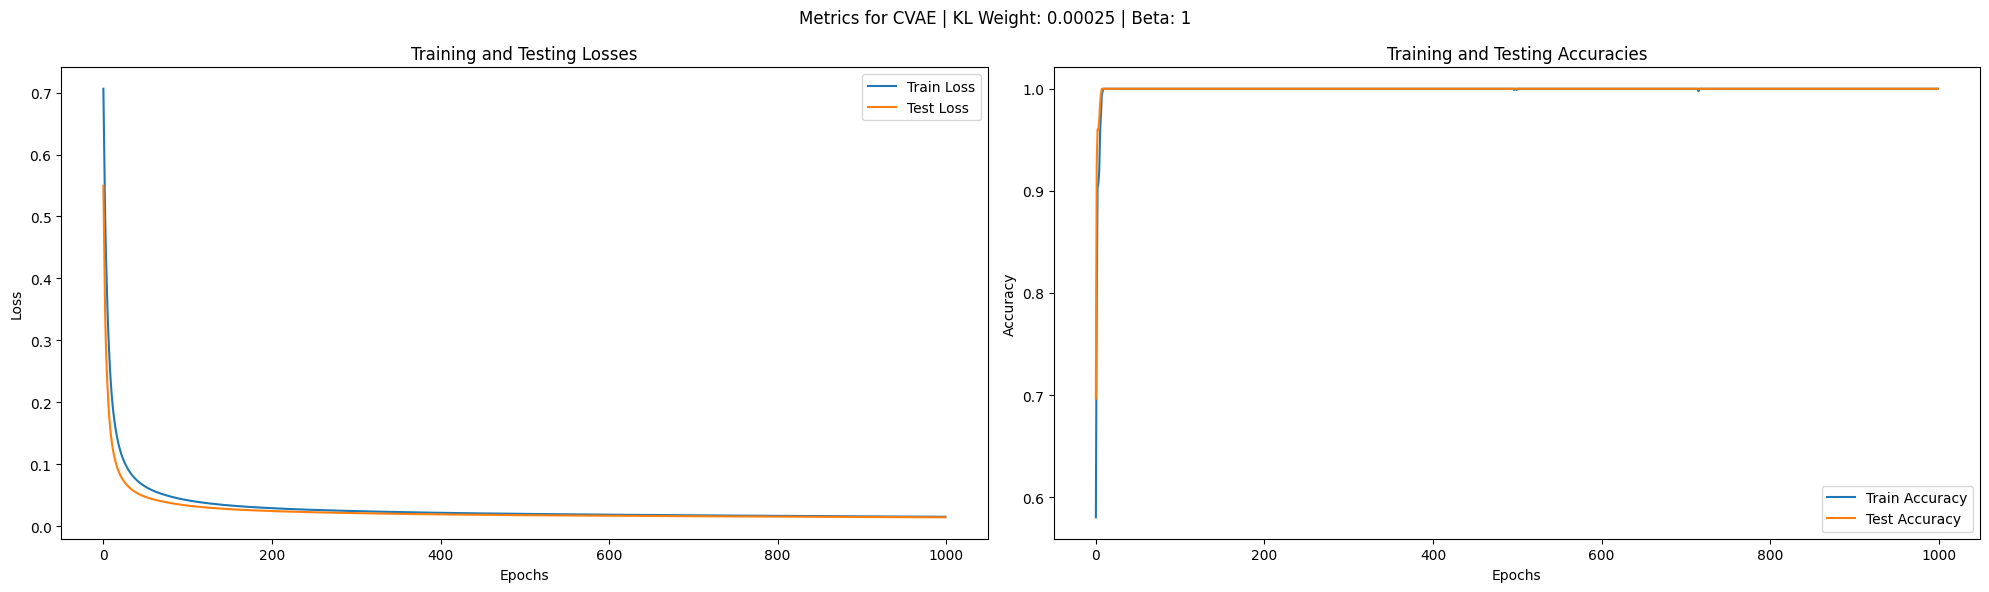

In [19]:
# Extract metrics for plotting
epochs = [metrics['epoch'] for metrics in epoch_metrics_list]
train_losses = [metrics['mean_loss'] for metrics in epoch_metrics_list]
test_losses = [metrics['mean_loss_test'] for metrics in epoch_metrics_list]
train_accuracies = [metrics['accuracy'] for metrics in epoch_metrics_list]
test_accuracies = [metrics['test_accuracy'] for metrics in epoch_metrics_list]

# Plotting example
plt.figure(figsize=(20, 6))
plt.suptitle(f"Metrics for CVAE | KL Weight: {kl_weight} | Beta: {beta}")

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', linestyle='-')
plt.plot(epochs, test_losses, label='Test Loss', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Losses')
plt.legend()

# Plot for non-healthy data
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', linestyle='-')
plt.plot(epochs, test_accuracies, label='Test Accuracy', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracies')
plt.legend()

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

## Show a simple example of reconstructed signal

### Train Set

In [20]:
# Variables needed to iterate over train and test loaders for plotting purposes
test_iter = iter(test_loader)
train_iter = iter(train_loader)

X shape: torch.Size([125, 11])
Motor tasks shape: torch.Size([125])
Conditions shape: torch.Size([125])
Predicted accuracy for this batch: 100.00%


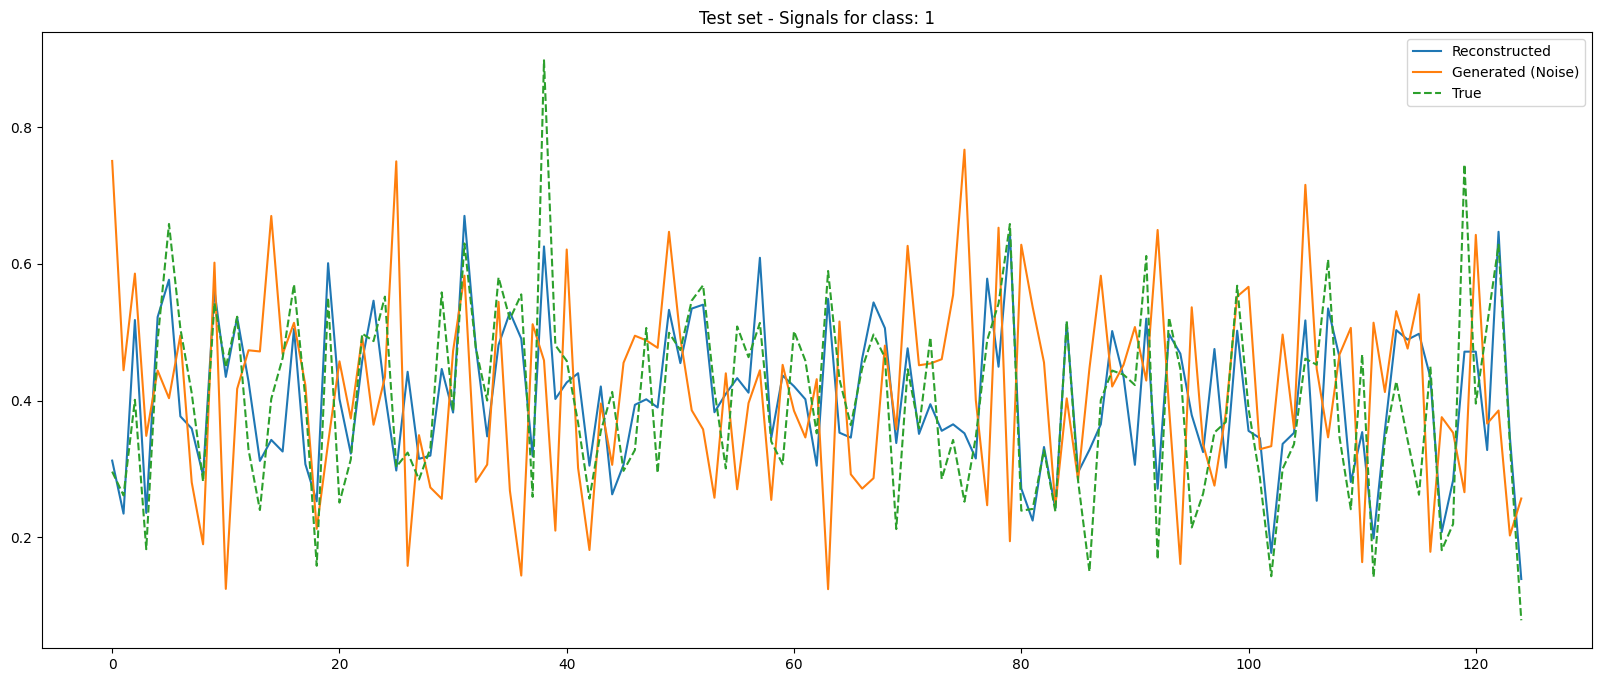

In [21]:
# Plotting example
current_sample_count = 0
concatenated_batches = []
dict_chann = {'Fc1': 2, 'Cp6': 10} # C3 is 2nd channel, Cp5 is 10th channel

# Variables to tweak for plotting
channel_to_show = dict_chann['Fc1']
len_signal = 125
class_to_reconstruct = 1 # Healthy = 0 / Unhealthy = 1

while current_sample_count < len_signal:
    try:
        x_batch, motor_tasks_batch, conditions_batch = next(train_iter)
        filtered_indices = conditions_batch == class_to_reconstruct
        conditions_batch = conditions_batch[filtered_indices]
        x_batch = x_batch[filtered_indices]
        motor_tasks_batch = motor_tasks_batch[filtered_indices]

        concatenated_batches.append((x_batch, motor_tasks_batch, conditions_batch))
        current_sample_count += x_batch.size(0)  # Increment by the batch size
    except StopIteration:
        # If you reach the end of the loader, restart the iterator
        train_iter = iter(train_loader)

# Concatenate the batches
x_concatenated = torch.cat([batch[0] for batch in concatenated_batches], dim=0)[:len_signal, :]
motor_tasks_concatenated = torch.cat([batch[1] for batch in concatenated_batches], dim=0)[:len_signal]
conditions_concatenated = torch.cat([batch[2] for batch in concatenated_batches], dim=0)[:len_signal]
# Print the shape of the various concatenated tensors
print(f"X shape: {x_concatenated.shape}")
print(f"Motor tasks shape: {motor_tasks_concatenated.shape}")
print(f"Conditions shape: {conditions_concatenated.shape}")

# Move data to GPU if available
x_concatenated = x_concatenated.to(device=device)
conditions_concatenated = conditions_concatenated.to(device=device).long()

# Classification head
y_oh = torch.nn.functional.one_hot(conditions_concatenated, num_classes=num_classes)
mu, logvar = cvae.encoder(x_concatenated, y_oh)
z = cvae.reparameterize(mu, logvar)
logits, probs = cvae.classification_head(z)

# Compute accuracy
predicted_labels = torch.argmax(probs, dim=1)
correct_predictions += (predicted_labels == conditions_concatenated).sum().item()
total_samples += conditions_concatenated.size(0)

# Get the reconstructed data
reconstructed_data, _, _ = cvae(x_concatenated, conditions_concatenated)

# Generate samples from random noise
y_oh = torch.nn.functional.one_hot(torch.zeros(len_signal, dtype=torch.long, device=device), num_classes=num_classes)
generated_samples = cvae.sample(len_signal, y_oh)

# Calculate and plot the summed signals
x_concatenated = x_concatenated.detach().cpu().numpy()
generated_samples = generated_samples.detach().cpu().numpy()
reconstructed_data = reconstructed_data.detach().cpu().numpy()

# Plot the true and generated signals
print("Predicted accuracy for this batch: {:.2f}%".format(correct_predictions / total_samples * 100))
plt.figure(figsize=(20, 8))
plt.plot(reconstructed_data[:, channel_to_show], label='Reconstructed', linestyle='-')
plt.plot(generated_samples[:, channel_to_show], label='Generated (Noise)')
plt.plot(x_concatenated[:, channel_to_show], label='True', linestyle='--')
plt.title(F"Test set - Signals for class: {class_to_reconstruct}")
plt.legend()
plt.show()

### Test Set

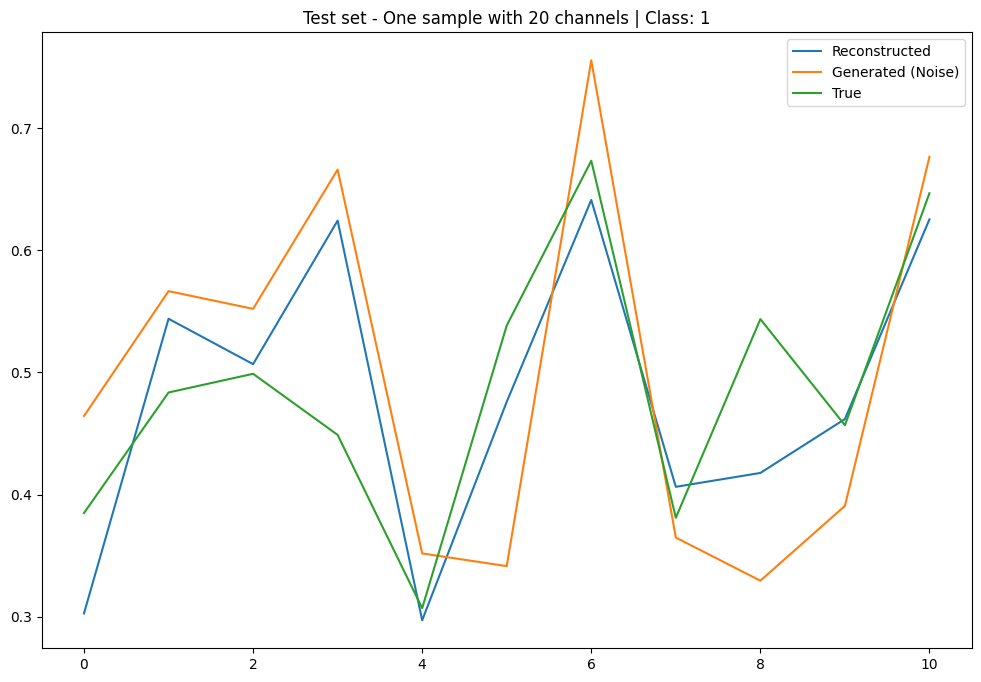

In [22]:
# Get a single batch from the test_loader
x_batch, motor_tasks_batch, conditions_batch = next(iter(test_loader))

# Pick a random sample from the batch between 0 and 64
sample_to_show = random.randint(0, batch_size - 1)
class_to_reconstruct = conditions_batch[sample_to_show].item()
x_batch = x_batch[sample_to_show].unsqueeze(0)
conditions_batch = conditions_batch[sample_to_show].unsqueeze(0)

# Move data to GPU if available
x_batch = x_batch.to(device=device)
conditions_batch = conditions_batch.to(device=device).long()

# Classification head
y_oh = torch.nn.functional.one_hot(conditions_batch, num_classes=num_classes)
mu, logvar = cvae.encoder(x_batch, y_oh)
z = cvae.reparameterize(mu, logvar)
logits, probs = cvae.classification_head(z)

# Get the reconstructed data
reconstructed_data, _, _ = cvae(x_batch, conditions_batch)
cvae_sample = reconstructed_data.detach().cpu().numpy()

# Generate samples from random noise
generated_samples = cvae.sample(1, y_oh).detach().cpu().numpy()
generated_signal_sampled = np.sum(generated_samples, axis=0)

# Calculate and plot the summed signals
true_signal = np.sum(x_batch.cpu().numpy(), axis=0)
generated_signal = np.sum(cvae_sample, axis=0)

# Plot the true and generated signals
plt.figure(figsize=(12, 8))
plt.plot(generated_signal, label='Reconstructed')
plt.plot(generated_signal_sampled, label='Generated (Noise)')
plt.plot(true_signal, label='True')
plt.title(F"Test set - One sample with 20 channels | Class: {int(class_to_reconstruct)}")
plt.legend()
plt.show()

X shape: torch.Size([125, 11])
Motor tasks shape: torch.Size([125])
Conditions shape: torch.Size([125])
Predicted accuracy for this batch: 100.00%
Loss between true and generated signals: 0.0333


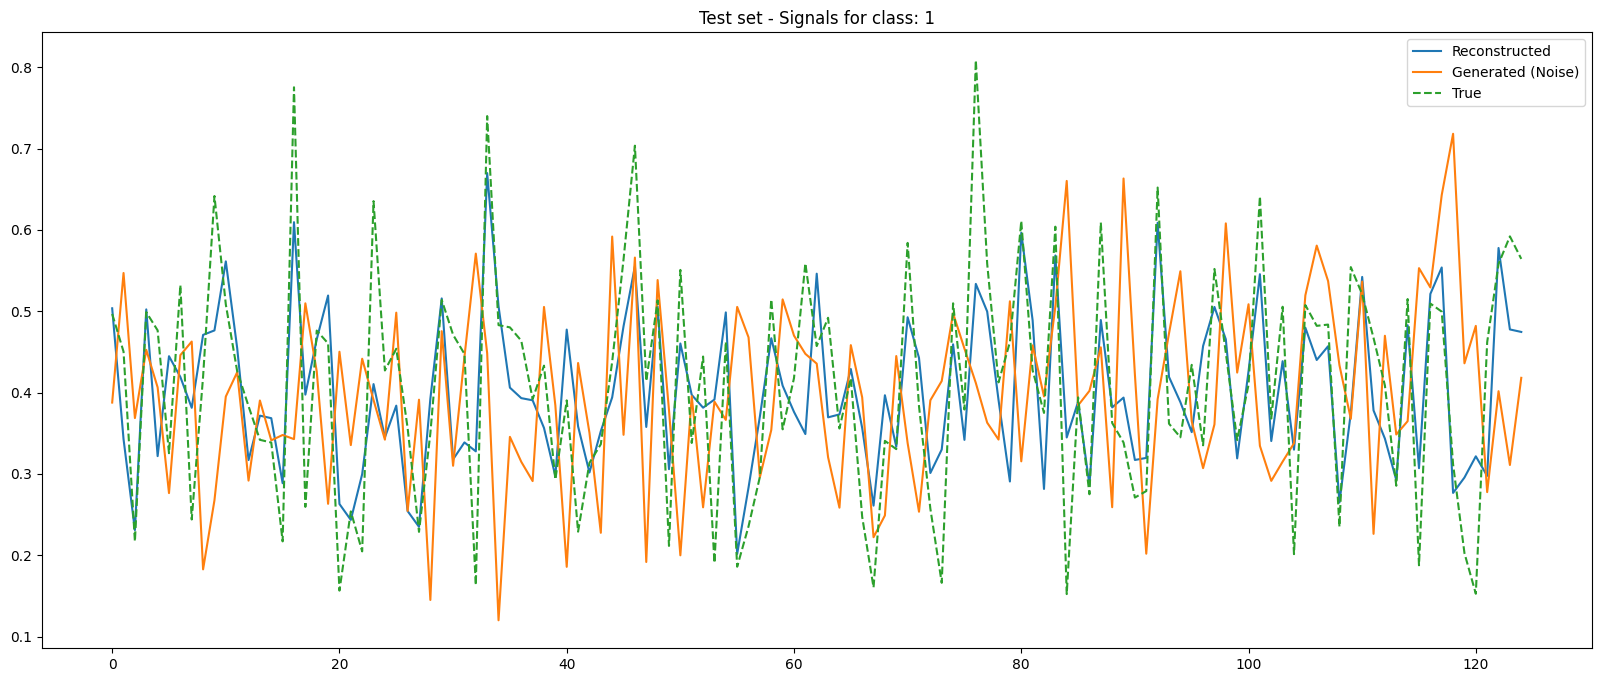

In [23]:
# Plotting example
current_sample_count = 0
concatenated_batches = []
dict_chann = {'Fc1': 2, 'Cp6': 10} # C3 is 2nd channel, Cp5 is 10th channel

# Variables to tweak for plotting
channel_to_show = dict_chann['Fc1']
len_signal = 125
class_to_reconstruct = 1 # Healthy = 0 / Unhealthy = 1

while current_sample_count < len_signal:
    try:
        x_batch, motor_tasks_batch, conditions_batch = next(test_iter)
        filtered_indices = conditions_batch == class_to_reconstruct
        conditions_batch = conditions_batch[filtered_indices]
        x_batch = x_batch[filtered_indices]
        motor_tasks_batch = motor_tasks_batch[filtered_indices]

        concatenated_batches.append((x_batch, motor_tasks_batch, conditions_batch))
        current_sample_count += x_batch.size(0)  # Increment by the batch size
    except StopIteration:
        # If you reach the end of the loader, restart the iterator
        test_iter = iter(test_loader)

# Concatenate the batches
x_concatenated = torch.cat([batch[0] for batch in concatenated_batches], dim=0)[:len_signal, :]
motor_tasks_concatenated = torch.cat([batch[1] for batch in concatenated_batches], dim=0)[:len_signal]
conditions_concatenated = torch.cat([batch[2] for batch in concatenated_batches], dim=0)[:len_signal]
# Print the shape of the various concatenated tensors
print(f"X shape: {x_concatenated.shape}")
print(f"Motor tasks shape: {motor_tasks_concatenated.shape}")
print(f"Conditions shape: {conditions_concatenated.shape}")

# Move data to GPU if available
x_concatenated = x_concatenated.to(device=device)
conditions_concatenated = conditions_concatenated.to(device=device).long()

# Classification head
y_oh = torch.nn.functional.one_hot(conditions_concatenated, num_classes=num_classes)
mu, logvar = cvae.encoder(x_concatenated, y_oh)
z = cvae.reparameterize(mu, logvar)
logits, probs = cvae.classification_head(z)

# Compute accuracy
predicted_labels = torch.argmax(probs, dim=1)
correct_predictions += (predicted_labels == conditions_concatenated).sum().item()
total_samples += conditions_concatenated.size(0)

# Get the reconstructed data
reconstructed_data, _, _ = cvae(x_concatenated, conditions_concatenated)

# Generate samples from random noise
y_oh = torch.nn.functional.one_hot(torch.zeros(len_signal, dtype=torch.long, device=device), num_classes=num_classes)
generated_samples = cvae.sample(len_signal, y_oh)

# Calculate loss between the true and generated signals
reconstruction_loss = criterion(generated_samples, x_concatenated)

# Calculate and plot the summed signals
x_concatenated = x_concatenated.detach().cpu().numpy()
generated_samples = generated_samples.detach().cpu().numpy()
reconstructed_data = reconstructed_data.detach().cpu().numpy()

# Plot the true and generated signals
print("Predicted accuracy for this batch: {:.2f}%".format(correct_predictions / total_samples * 100))
print("Loss between true and generated signals: {:.4f}".format(reconstruction_loss))
plt.figure(figsize=(20, 8))
plt.plot(reconstructed_data[:, channel_to_show], label='Reconstructed', linestyle='-')
plt.plot(generated_samples[:, channel_to_show], label='Generated (Noise)')
plt.plot(x_concatenated[:, channel_to_show], label='True', linestyle='--')
plt.title(F"Test set - Signals for class: {class_to_reconstruct}")
plt.legend()
plt.show()